# Compare ROH between groups
Load empirical ROH Dataframe, and compare ROH sharing between groups with statistical tests (producing p-Values)
Assumes data is ROH analyzed, and pre-processed (into one dataframe, with region and clst Columns set.

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from math import log10, floor

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
from scipy.stats import mannwhitneyu

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Mann Whitney U Test

In [175]:
def test_mwu(df, region1="Iberia", region2="Iberia", clst1="Early Neolithic", clst2="Neolithic", 
             col="sum_roh_4-8", prt=True, alternative='two-sided', col_group="region"):
    """MWann Whitney U-Test. Print and return result and nr Individuals in each group
    df: Dataframe to test on
    prt: Whether to print the results"""
    df1 = df[(df["clst"]==clst1) & (df[col_group]==region1)]
    df2 = df[(df["clst"]==clst2) & (df[col_group]==region2)]
    
    test = mannwhitneyu(df1[col], df2[col], alternative=alternative)
    if prt:
        print(test)
        print(f"Loaded {len(df1)} Samples from clst {clst1} {region1}")
        print(f"Loaded {len(df2)} Samples from clst {clst2} {region2}")
        
    return test, len(df1), len(df2)

def test_mwu_groups(df1, df2, col="sum_roh_4-8",
                    prt=True, alternative='two-sided'):
    """Compare two Dataframes with values in col with mannwhitneyu Test"""
    test = mannwhitneyu(df1[col], df2[col], alternative=alternative)
    mean2 = np.mean(df2[col])
    mean1 = np.mean(df1[col])
    mean_diff =  mean2 - mean1
    
    if prt:
        print(test)
        print(f"Loaded {len(df1)} Samples Set1")
        print(f"Loaded {len(df2)} Samples Set2") 
        print(f"Mean 1: {mean1:.4f}")
        print(f"Mean 2: {mean2:.4f}")
        print(f"Mean difference 2 - 1: {mean_diff:.4f}")
    return test, len(df1), len(df2)

def load_ROH_nolong(path="./Empirical/roh_all_inds_final_v42.csv",
                    cm=20, cutoff=50):
    """Load Dataframe without ROH"""
    df = pd.read_csv(path, sep='\t')
    df["sum_roh_4-8"] = df["sum_roh>4"] - df["sum_roh>8"]
    print(f"Loaded {len(df)} Individuals")
    df = df[df[f"sum_roh>{cm}"]<cutoff]
    print(f"Filtered to {len(df)} Individuals with no long ROH")
    return df

def compare_groups(df1, df2, col="sum_roh_4-8",
                   label1="", label2="",
                   alternative="two-sided", sig=2, pr=False):
    
    df = pd.DataFrame({"Group A":[label1], "Group B":[label2]})
    
    ### Set the summary Stats
    df["Median A"] = np.median(df1[col])
    df["#Zero A"] = np.sum(df1[col]==0) 
    df["# A"]= len(df1)
    df["Median B"] = np.median(df2[col])
    df["#Zero B"] = np.sum(df2[col]==0)
    df["# B"] = len(df2)
    
    ### Set the p-Value
    test = mannwhitneyu(df1[col], df2[col], alternative=alternative)
    #df["p"] = round_sig(test[1], sig=sig)
    df["p"] = test[1]
    df["p"] = df["p"].apply(lambda x: '{:.1e}'.format(x))
    
    if pr:
        print_latex(df)
    return df

def round_sig(x, sig=2):
    """Round to Significant digits.
    Return rounded number"""
    return round(x, sig-int(floor(log10(abs(x))))-1)

def print_latex(df, index=False,  float_format="%.1f", ret=False):
    """Print Latex table from Dataframe"""
    out = df.to_latex(index=index, float_format=float_format)
    print(out)

    if ret:
        return out

# Early HG vrs later HG

In [179]:
df = load_ROH_nolong(path="./Empirical/roh_all_inds_final_v42.csv")
df1 = df[(df["age"]>0) & (df["age"]<100000)]
print(f"Filtered to {len(df1)} Inviduals in age range")
df_hg = df1[(df1["economy"]=="Hunter Gatherer")]

Loaded 3732 Individuals
Filtered to 3497 Individuals with no long ROH
Filtered to 1739 Inviduals in age range


In [167]:
df_hg1 =  df_hg[df_hg["age"]>10e3]
df_hg2 =  df_hg[(df_hg["age"]>8e3) & (df_hg["age"]<10e3)]

In [181]:
df_add = compare_groups(df_hg1, df_hg2, label1 = "HG > 10k BP",  label2 = "HG  8-10k BP", pr=True)

\begin{tabular}{llrrrrrrl}
\toprule
     Group A &       Group B &  Median A &  \#Zero A &  \# A &  Median B &  \#Zero B &  \# B &        p \\
\midrule
 HG > 10k BP &  HG  8-10k BP &      30.5 &        0 &   22 &      14.1 &        3 &   37 &  1.5e-04 \\
\bottomrule
\end{tabular}



In [ ]:
df_hg1

# EEF vrs HG Table [Paper]

In [82]:
df = load_ROH_nolong(path="./Empirical/roh_all_inds_final_v42.csv")
df1 = df[(df["age"]>0) & (df["age"]<100000)]
print(f"Filtered to {len(df1)} Inviduals in age range")
df_hg = df1[(df1["economy"]=="Hunter Gatherer")]
df_ef = df1[(df1["economy"]=="Agricultural")]
#set(df_hg["region"])

Loaded 3732 Individuals
Filtered to 3497 Individuals with no long ROH
Filtered to 1739 Inviduals in age range


### All HG vrs Agriculturalists

In [86]:
df_add = compare_groups(df_hg, df_ef, label1 = "All HG",  label2 = "All Farmers", pr=True)

\begin{tabular}{llrrrrrrl}
\toprule
Group A &      Group B &  Median A &  \#Zero A &  \# A &  Median B &  \#Zero B &  \# B &         p \\
\midrule
 All HG &  All Farmers &      17.0 &       16 &  138 &       0.0 &      543 &  921 &  2.31e-47 \\
\bottomrule
\end{tabular}



# HG vrs early Agriculturalists

In [171]:
df = load_ROH_nolong(path="./Empirical/roh_all_inds_final_v42.csv")
df1 = df[(df["age"]>0) & (df["age"]<100000)]
print(f"Filtered to {len(df1)} Inviduals in age range")
df_hg = df1[(df1["economy"]=="Hunter Gatherer")]
df_ef = df1[(df1["economy"]=="Agricultural")]

regions = ['Aegan', 'Balkans', 
           'Britain', 'Central Europe',
           'Iberia', 'Rome', 'Steppe', 
           'Black Sea', 'North Africa',  "Baltic Sea"]
# 'North Africa'  'Baltic Sea', 
 #          'Black Sea'
df_efs = []  # Fill up with 
df_vec = []

for r in regions:
    df1 = df_hg[df_hg["region"]==r]
    df2 = df_ef[df_ef["region"]==r]
    
    # Set age boundary
    age_max = np.max(df2["age"])
    df3 = df2[df2["age"]> (age_max-2000)].reset_index()
    df_efs.append(df3)
    print(f"{r}: Reduced to {len(df3)}/{len(df2)}, Age Max: {age_max}")
    label1 = r + "-HG"
    label2 = r + "-EF"
    df_add = compare_groups(df1, df3, label1 = label1,  label2 = label2)
    df_vec.append(df_add)
df_res = pd.concat(df_vec)

Loaded 3732 Individuals
Filtered to 3497 Individuals with no long ROH
Filtered to 1739 Inviduals in age range
Aegan: Reduced to 27/47, Age Max: 8505.0
Balkans: Reduced to 41/101, Age Max: 7836.0
Britain: Reduced to 90/135, Age Max: 5770.0
Central Europe: Reduced to 25/129, Age Max: 7140.0
Iberia: Reduced to 20/128, Age Max: 7348.0
Rome: Reduced to 11/120, Age Max: 7984.0
Steppe: Reduced to 10/10, Age Max: 5456.0
Black Sea: Reduced to 3/3, Age Max: 4754.0
North Africa: Reduced to 1/1, Age Max: 3635.0
Baltic Sea: Reduced to 10/10, Age Max: 1431.0


In [172]:
print(df_res.to_latex(index=False,  float_format="%.1f"))

\begin{tabular}{llrrrrrrl}
\toprule
           Group A &            Group B &  Median A &  \#Zero A &  \# A &  Median B &  \#Zero B &  \# B &        p \\
\midrule
          Aegan-HG &           Aegan-EF &      30.9 &        0 &    1 &       0.0 &       18 &   27 &  6.0e-02 \\
        Balkans-HG &         Balkans-EF &      13.3 &        3 &   37 &       4.2 &       17 &   41 &  5.5e-06 \\
        Britain-HG &         Britain-EF &      39.8 &        0 &    1 &       5.6 &       18 &   90 &  8.9e-02 \\
 Central Europe-HG &  Central Europe-EF &      42.8 &        0 &    1 &       0.0 &       15 &   25 &  7.5e-02 \\
         Iberia-HG &          Iberia-EF &      25.6 &        0 &    4 &       4.7 &        7 &   20 &  1.5e-01 \\
           Rome-HG &            Rome-EF &      65.8 &        0 &    2 &       4.4 &        5 &   11 &  3.3e-02 \\
         Steppe-HG &          Steppe-EF &      39.2 &        2 &   12 &       7.1 &        3 &   10 &  1.9e-02 \\
      Black Sea-HG &       Black Sea-EF

### HG vrs Early Farmers 
Needs above function

In [178]:
df1 = pd.concat(df_efs)
df_res = compare_groups(df_hg, df1, label1 = "All HG",  label2 = "Early Farmers (EF)", pr=True)

\begin{tabular}{llrrrrrrl}
\toprule
Group A &             Group B &  Median A &  \#Zero A &  \# A &  Median B &  \#Zero B &  \# B &        p \\
\midrule
 All HG &  Early Farmers (EF) &      17.0 &       16 &  138 &       4.5 &       91 &  238 &  3.1e-22 \\
\bottomrule
\end{tabular}



### Iberia

In [103]:
df = load_ROH_nolong(path="./Empirical/roh_all_inds_final_v42.csv")
df_ef = df[(df["economy"]=="Agricultural")]
df1 = df_ef[df_ef["pop"].str.contains("Iberia_EN")]
df2 = df_ef[df_ef["pop"].str.contains("Iberia_MN")]

Loaded 3732 Individuals
Filtered to 3497 Individuals with no long ROH


In [106]:
df_add = compare_groups(df1, df2, label1 = "Iberia-EN",  label2 = "Iberia-MN", pr=True)

\begin{tabular}{llrrrrrrl}
\toprule
   Group A &    Group B &  Median A &  \#Zero A &  \# A &  Median B &  \#Zero B &  \# B &         p \\
\midrule
 Iberia-EN &  Iberia-MN &      21.8 &        5 &   34 &       0.0 &        6 &   10 &  5.45e-04 \\
\bottomrule
\end{tabular}



### Aceramic to Anatolia-N

In [127]:
df = load_ROH_nolong(path="./Empirical/roh_all_inds_final_v42.csv")

df_ac = df[(df["economy"]=="Aceramic Farmer")]
df1 = df_ac[df_ac["pop"].str.contains("Anatolia")]

df_ef = df[(df["economy"]=="Agricultural")]
df2 = df_ef[df_ef["pop"].str.contains("Anatolia_N")]

Loaded 3732 Individuals
Filtered to 3497 Individuals with no long ROH


In [128]:
df_add = compare_groups(df1, df2, label1 = "Anatolia-AC",  label2 = "Anatolia-N", pr=True)

\begin{tabular}{llrrrrrrl}
\toprule
     Group A &     Group B &  Median A &  \#Zero A &  \# A &  Median B &  \#Zero B &  \# B &         p \\
\midrule
 Anatolia-AC &  Anatolia-N &      36.7 &        0 &    6 &       0.0 &       18 &   23 &  8.92e-05 \\
\bottomrule
\end{tabular}



In [ ]:
df1

### Tests of Mann Whitney U Test

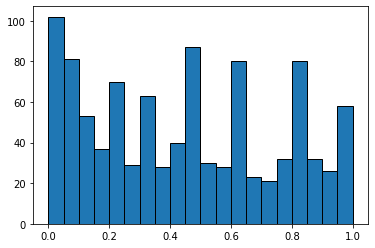

CPU times: user 490 ms, sys: 7.83 ms, total: 498 ms
Wall time: 496 ms


In [195]:
%%time
reps = 1000
mean1, mean2 = 3.0, 3.0
s1, s2 = 100, 100
std1, std2 = 1.0, 100.0

p = np.zeros(reps)

for i in range(reps):
    x = np.random.normal(loc=mean1, scale=std1, size=s1)
    y = np.random.normal(loc=mean2, scale=std2, size=s2)
    p[i] = mannwhitneyu(x, y, alternative='two-sided')[1]
    
#### 
# Plot figures of distribution p-Values
plt.figure()
ax = plt.gca()
ax.hist(p, bins=20, ec="k")
plt.show()

### Apply to empirical Data

In [2]:
### Load Big Data Frame (only ancients)
df = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df = df[df["age"]>0]
df["sum_roh_4-8"] = df["sum_roh>4"] - df["sum_roh>8"]

In [44]:
for reg in ["Iberia", "Balkans", "Rome", "Central Europe", "Black Sea", "Baltic Sea"]:
    test_mwu(df, region1=reg, region2=reg, clst1="Mesolithic", clst2="Early Neolithic")
    test_mwu(df, region1=reg, region2=reg, clst1="Early Neolithic", clst2="Neolithic")
    test_mwu(df, region1=reg, region2=reg, clst1="Mesolithic", clst2="Neolithic")
    print("\n")

MannwhitneyuResult(statistic=19.0, pvalue=0.8303242576557953)
Loaded 7 Samples from clst Mesolithic Iberia
Loaded 6 Samples from clst Early Neolithic Iberia
MannwhitneyuResult(statistic=128.0, pvalue=0.0038670303618025593)
Loaded 6 Samples from clst Early Neolithic Iberia
Loaded 24 Samples from clst Neolithic Iberia
MannwhitneyuResult(statistic=158.0, pvalue=0.000492384005230395)
Loaded 7 Samples from clst Mesolithic Iberia
Loaded 24 Samples from clst Neolithic Iberia


MannwhitneyuResult(statistic=302.0, pvalue=0.06454672358949157)
Loaded 37 Samples from clst Mesolithic Balkans
Loaded 12 Samples from clst Early Neolithic Balkans
MannwhitneyuResult(statistic=238.0, pvalue=0.22913306771562947)
Loaded 12 Samples from clst Early Neolithic Balkans
Loaded 32 Samples from clst Neolithic Balkans
MannwhitneyuResult(statistic=970.0, pvalue=5.524253515214728e-06)
Loaded 37 Samples from clst Mesolithic Balkans
Loaded 32 Samples from clst Neolithic Balkans


MannwhitneyuResult(statistic=27.0, pval

/home/hringbauer/.local/lib/python3.7/site-packages/scipy/stats/stats.py:5700: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


# Tests for Papers

In [13]:
df = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
df["sum_roh_4-8"] = df["sum_roh>4"] - df["sum_roh>8"]
print(f"Loaded {len(df)} Individuals")
df = df[df["sum_roh>20"]<50]
print(f"Filtered to {len(df)} Individuals with no long ROH")
df_anc =df[df["age"]>0]
print(f"Loaded {len(df_anc)} Ancients")
print(set(df_anc["economy"]))

df_hg = df[(df["economy"]=="Hunter Gatherer")]
df_ef = df[(df["economy"]=="Agricultural")]

Loaded 3732 Individuals
Filtered to 3497 Individuals with no long ROH
Loaded 1739 Ancients
{nan, 'Hunter Gatherer', 'unknown', 'Agricultural ', 'Pastoralist mixed', 'Pastoralist', 'Agricultural mixed', 'Hunter Gatherer mixed', 'Agricultural', 'Aceramic Farmer'}


In [14]:
df1 = df_anc[df_anc["age"]>10e3]
df2 =df_anc[df_anc["age"]<5e3]
test_mwu_groups(df1, df2)

NameError: name 'test_mwu_groups' is not defined

### Tests 10-5k years ago

In [56]:
df = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep='\t')
df["sum_roh_4-8"] = df["sum_roh>4"] - df["sum_roh>8"]
print(f"Loaded {len(df)} Individuals")
df = df[df["sum_roh>20"]<50]
print(f"Filtered to {len(df)} Individuals with no long ROH")

df1 = df[(df["age"]>5000) & (df["age"]<100000)]
print(f"Filtered to {len(df1)} Inviduals in age range")
df_hg = df1[(df1["economy"]=="Hunter Gatherer")]
df_ef = df1[(df1["economy"]=="Agricultural")]

Loaded 3732 Individuals
Filtered to 3497 Individuals with no long ROH
Filtered to 493 Inviduals in age range


In [57]:
df_hg["region"].value_counts()

Balkans           37
Baltic Sea        33
East Steppe       15
Black Sea         14
Steppe            11
all                7
Iberia             4
North Africa       3
Rome               2
Central Europe     1
Aegan              1
Britain            1
Name: region, dtype: int64

In [16]:
region = "Rome"
df1 = df_hg[df_hg["region"]==region]
df2 = df_ef[df_ef["region"]==region]
test_mwu_groups(df1, df2)

MannwhitneyuResult(statistic=240.0, pvalue=0.0005176262553425429)
Loaded 2 Samples Set1
Loaded 120 Samples Set2
Mean 1: 65.8350
Mean 2: 1.4111
Mean difference 2 - 1: -64.4239


(MannwhitneyuResult(statistic=240.0, pvalue=0.0005176262553425429), 2, 120)

In [27]:
test_mwu_groups(df1, df2)

MannwhitneyuResult(statistic=240.0, pvalue=0.0005176262553425429)
Loaded 2 Samples Set1
Loaded 120 Samples Set2
Mean 1: 65.8350
Mean 2: 1.4111
Mean difference 2 - 1: -64.4239


(MannwhitneyuResult(statistic=240.0, pvalue=0.0005176262553425429), 2, 120)

# Produce Table for Paper"
Produce Dataframes - these are then concatenated and saved into ./tablesout

In [4]:
regions = ["Iberia", "Balkans", "Rome", "Central Europe", "Black Sea", "Baltic Sea"]
periods = ["Mesolithic", "Early Neolithic", "Neolithic"]
prt = False

p1_vec, p2_vec = [], []
n1_vec, n2_vec = [], []
st_vec, p_vec = [], []

for reg in regions:
    for ps in it.combinations(periods, 2):
        t, i1, i2 = test_mwu(df, region1=reg, region2=reg, clst1=ps[0], clst2=ps[1], prt=prt)
        if (i1>0) and (i2>0):
            n1_vec.append(i1)
            n2_vec.append(i2)
            p1_vec.append(ps[0] + " " + reg)
            p2_vec.append(ps[1] + " " + reg)
            st_vec.append(t[0])
            p_vec.append(t[1])
            
#### Combine into one dataframe
df_res = pd.DataFrame({"Population 1": p1_vec, "Population 2": p2_vec, 
              "n1": n1_vec, "n2": n2_vec, "Statistic": st_vec, "p-Value": p_vec})

/home/hringbauer/.local/lib/python3.7/site-packages/scipy/stats/stats.py:5700: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


### Compare all Mesolithic Populations

In [5]:
regions = ["Iberia", "Balkans", "Rome", "Central Europe", "Black Sea", "Baltic Sea"]
periods = ["Mesolithic", "Early Neolithic", "Neolithic"]
prt = False

p1_vec, p2_vec = [], []
n1_vec, n2_vec = [], []
st_vec, p_vec = [], []

for prd in periods:
    for rgs in it.combinations(regions, 2):
        t, i1, i2 = test_mwu(df, region1=rgs[0], region2=rgs[1], clst1=prd, clst2=prd, prt=prt)
        if (i1>0) and (i2>0):
            n1_vec.append(i1)
            n2_vec.append(i2)
            p1_vec.append(prd + " " + rgs[0])
            p2_vec.append(prd + " " + rgs[1])
            st_vec.append(t[0])
            p_vec.append(t[1])
            
#### Combine into one dataframe
df_res1 = pd.DataFrame({"Population 1": p1_vec, "Population 2": p2_vec, 
              "n1": n1_vec, "n2": n2_vec, "Statistic": st_vec, "p-Value": p_vec})

/home/hringbauer/.local/lib/python3.7/site-packages/scipy/stats/stats.py:5700: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


### Combine and save final dataframe

In [6]:
df_res = pd.concat([df_res, df_res1])

In [7]:
savepath = "./TablesOut/p_vals_shifts.csv"
df_res.to_csv(savepath, index=False, header=True)
print(f"Saved to {savepath}")

Saved to ./TablesOut/p_vals_shifts.csv


In [8]:
df_res.head(10)

,Population 1,Population 2,n1,n2,Statistic,p-Value
0,Mesolithic Iberia,Early Neolithic Iberia,7,6,19.0,0.830324
1,Mesolithic Iberia,Neolithic Iberia,7,24,158.0,0.000492
2,Early Neolithic Iberia,Neolithic Iberia,6,24,128.0,0.003867
3,Mesolithic Balkans,Early Neolithic Balkans,37,12,302.0,0.064547
4,Mesolithic Balkans,Neolithic Balkans,37,32,970.0,0.000006
5,Early Neolithic Balkans,Neolithic Balkans,12,32,238.0,0.229133
6,Mesolithic Rome,Early Neolithic Rome,3,9,27.0,0.016044
7,Mesolithic Central Europe,Early Neolithic Central Europe,4,20,80.0,0.002119
8,Mesolithic Central Europe,Neolithic Central Europe,4,5,20.0,0.019964
9,Early Neolithic Central Europe,Neolithic Central Europe,20,5,30.0,0.183555


## Analysis for Sirak-Fernandez Paper

In [17]:
df_t = pd.read_csv("./Empirical/Eigenstrat/Sirak20/combined_roh05.csv", sep="\t")
df_t["sum_roh_4-8"] = df_t["sum_roh>4"] - df_t["sum_roh>8"]

In [18]:
df_t[df_t["pop"].str.contains("Cuba")]

,iid,pop,max_roh,sum_roh>4,n_roh>4,sum_roh>8,n_roh>8,sum_roh>12,n_roh>12,sum_roh>20,...,lat,lon,age,age_range,study,clst,mean_cov,n_cov_snp,include_alt,sum_roh_4-8
6,I10937,Cuba_PC_Guanataybes_3000BP,19.245398,197.068783,28,89.078182,8,31.484496,2,0.000000,...,23.038894,-81.495252,3046,"1187-1004 calBCE (2890±20 BP, PSUAMS-4864)",Sirak20,Cuba_PC_Guanataybes_3000BP,0.622512,747014,1,107.990601
13,I13487,Cuba_unknown,25.732401,167.725115,22,52.622305,3,43.373004,2,25.732401,...,23.038894,-81.495252,2050,1400 BCE - 1200 CE,Sirak20,Cuba_unknown,0.442270,530724,1,115.102810
36,I11169,Cuba_PC_Guanataybes_1300BP,18.753999,96.583808,12,53.293002,4,43.730003,3,0.000000,...,23.038894,-81.495252,1322,"605-651 calCE (1425±15 BP, PSUAMS-4868)",Sirak20,Cuba_PC_Guanataybes_1300BP,0.621566,745879,1,43.290806
60,I10757,Cuba_PC_Guanataybes,8.214600,73.450202,14,8.214600,1,0.000000,0,0.000000,...,23.038894,-81.495252,2050,1400 BCE - 1200 CE,Sirak20,Cuba_PC_Guanataybes,0.613718,736461,1,65.235602
76,I10756,Cuba_PC_Guanataybes,8.663797,57.772303,10,16.693997,2,0.000000,0,0.000000,...,23.038894,-81.495252,868,"1016-1148 calCE (980±15 BP, PSUAMS-5340)",Sirak20,Cuba_PC_Guanataybes,0.623518,748222,1,41.078306


### Test Cuba Early / Late

In [35]:
df1 = df_t[(df_t["pop"].str.contains("Cuba")) & (df_t["age"] > 2000)]
df2 = df_t[(df_t["pop"].str.contains("Cuba")) & (df_t["age"] <= 2000)]

test_mwu_groups(df1, df2, col="sum_roh_4-8",
                prt=True, alternative='two-sided')

MannwhitneyuResult(statistic=6.0, pvalue=0.14891467317876572)
Loaded 3 Samples Set1
Loaded 2 Samples Set2


(MannwhitneyuResult(statistic=6.0, pvalue=0.14891467317876572), 3, 2)

### Test Cuba Early vrs Tainio

In [34]:
df1 = df_t[(df_t["pop"].str.contains("Cuba")) & (df_t["age"] > 2000)]
df2 = df_t[(df_t["pop"].str.contains("Dominican"))]

test_mwu_groups(df1, df2, col="sum_roh_4-8",
                prt=True, alternative='two-sided')

MannwhitneyuResult(statistic=340.0, pvalue=0.0036654464878695986)
Loaded 3 Samples Set1
Loaded 114 Samples Set2


(MannwhitneyuResult(statistic=340.0, pvalue=0.0036654464878695986), 3, 114)

### Test Venezuela

In [39]:
df1 = df_t[(df_t["pop"].str.contains("Venezuela")) & (df_t["age"] > 1000)]
df2 = df_t[(df_t["pop"].str.contains("Venezuela")) & (df_t["age"] <= 1000)]

test_mwu_groups(df1, df2, col="sum_roh_4-8",
                prt=True, alternative='two-sided')

MannwhitneyuResult(statistic=36.0, pvalue=0.027468640385681333)
Loaded 18 Samples Set1
Loaded 2 Samples Set2


(MannwhitneyuResult(statistic=36.0, pvalue=0.027468640385681333), 18, 2)

# Area 51